In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from atl_module.plotting import set_size

In [3]:
aoidflist = []
for aoifile in glob("../data/test_sites/oahu*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined_df = pd.concat(aoidflist)

In [4]:
tracklines_dflist = [
    gpd.read_file(file) for file in glob("../data/test_sites/oahu*/tracklines")
]
tracklines_combined = pd.concat(tracklines_dflist).reset_index()

In [5]:
dflist = []

for file in glob("../data/test_sites/oahu*/all_bathy_pts.gpkg"):
    df = gpd.read_file(file)
    sitename = file.split("/")[3].strip("oahu")
    df["Oahu site number"] = sitename
    dflist.append(df)

df = pd.concat(dflist).reset_index()

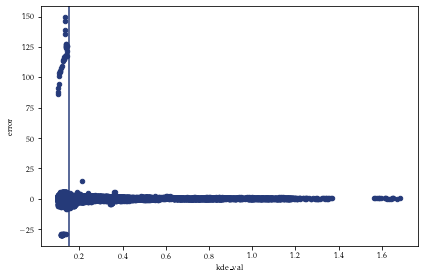

In [6]:
ax = df.plot.scatter(x="kde_val", y="error")
ax.axvline(0.15)

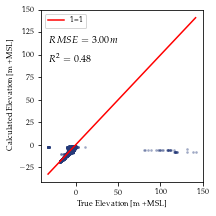

In [7]:
df_nona = df.dropna()
errordict = {
    "RMSE": df_nona.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df_nona.true_elevation, df_nona.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df_nona, "Oahu - All Subsites", errordict)
ax.get_figure().savefig(
    "../document/figures/Oahu_combined_lidar_estimated_vs_truth.pdf"
)

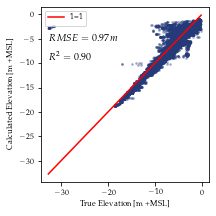

In [8]:
df_nona = df_nona[df_nona.true_elevation < 0]
errordict = {
    "RMSE": df_nona.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df_nona.true_elevation, df_nona.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df_nona, "Oahu - Excluding sea mountains", errordict)
ax.get_figure().savefig(
    "../document/figures/Oahu_combined_mountains_removed_lidar_estimated_vs_truth.pdf"
)

plotting photon map
finished plotting photons
finished adding basemap


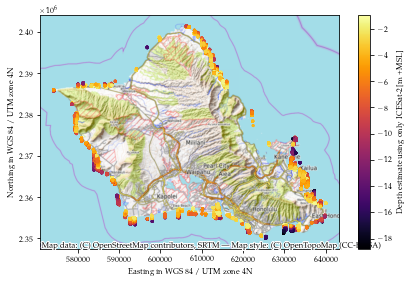

In [9]:
fig, ax = plt.subplots()
plot_photon_map(ax, df)
fig.savefig("../document/figures/Oahu_all_sites_photon_points.pdf")

In [15]:
minx, miny, maxx, maxy = tracklines_combined.total_bounds
# this ratio we can feed into the figure sizing function
scale_ratio = (maxx - minx) / (maxy - miny)
scale_ratio

1.3089821931211385

In [30]:
1/1.618

0.6180469715698392

plotting tracklines
finished plotting tracklines
finished plotting basemap


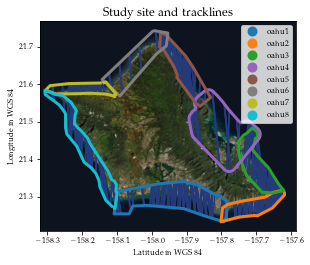

In [32]:
aoi_combined, trackax = plt.subplots(figsize=set_size(fraction = 0.8,ratio=scale_ratio))
plot_tracklines_overview(trackax, tracklines_combined)
aoi_combined_df.plot(
    column="site", categorical=True, legend=True, facecolor="none", lw=3, ax=trackax,zorder=2
)

aoi_combined.axes[0].set_ylabel('Latitude in WGS 84')
aoi_combined.axes[0].set_xlabel('Longitude in WGS 84')
# TODO fix categorical coloring on this

ax = aoi_combined.axes[0]
text = ax.texts[0]
text.set_visible(False)
aoi_combined.tight_layout()
aoi_combined.savefig("../document/figures/Oahu_all_tracklines.pdf")


In [27]:
text

Text(0.005, 0.005, 'Tiles (C) Esri -- Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [35]:
import numpy as np

rms_agg = lambda x: np.sqrt(np.mean(np.square(x)))

summary_table = (
    df.groupby("Oahu site number")
    .agg({"error": rms_agg, 
          "error_abs": "mean", 
          # "X": "count"
         })
    .rename(
        columns={
            "error": "RMSE",
            "error_abs": "MAE",
            # "X": "Count bathy Points Identified",
        }
    )
)
summary_table.style.format(precision=2).to_latex(
    buf="../document/tables/Oahu_all_sites_RMSE_summary.tex",
    caption="Error metrics between ICESat-2 and ground-truth data for all sites in Oahu",
    position="htbp",
    position_float='centering',
    sparse_columns=False,
    hrules=True,
    label="tab:Oahusitestats",
)
summary_table

,RMSE,MAE
Oahu site number,,
1,1.162525,0.768264
2,10.598899,1.447226
3,1.235144,0.463879
4,0.751631,0.565673
5,0.734813,0.504969
6,2.422447,1.756412
7,1.111055,0.717672
8,0.670030,0.520755
